In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping
import pandas as pd
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)


# number of data
N=4000
# size of each sample
L=2
# box size
B=100

!mkdir DATA

A subdirectory or file DATA already exists.


**Define non-linear functions**

In [42]:
def f(x,c=1):
    r=0
    if c==1:
        if x[0]>-25 and x[1]>-35 and x[0]+x[1] < 30:
            r=1
        if x[0]+x[1] > 50:
            r=1
    if c==2:
        if (np.sign(x[0]-0.2*x[1]))*np.cos(np.linalg.norm(x)/(1.5*np.pi))>0:
            r=1
    return r


def filename(s,TYPE=1):
    return "./DATA/"+s+"-for-DNN-"+str(TYPE)+".dat"

def boundaries():  
    x1=-25
    y1=-35
    c="#AAAAFF"
    a=0.5
    lw=5
    ax.plot((50,-20),(-20,50),c=c,alpha=a,lw=lw)
    ax.plot((50,0),(0,50),c=c,alpha=a,lw=lw)
    ax.plot((x1,50),(y1,y1),c=c,alpha=a,lw=lw)
    ax.plot((x1,x1),(y1,50),c=c,alpha=a,lw=lw)

def split_data_training_validation(data, labels,perc_train):
    #Number of total samples for distribution 2
    N=len(data)
#Training set
    perc_train=perc_train
    N_train = int(perc_train * N)

    #Split training and validation set 
    (data_train, label_train) = (data[0:N_train],labels[0:N_train])
    (data_valid, label_valid) = (data[N_train:],labels[N_train:])

    return(data_train, label_train, data_valid, label_valid)

#Rescale data
def Rescale(x):
    #return (x-x.mean())/np.sqrt(x.var())
    return x/50



**Generate Data (distribution 1 and 2)**

<function matplotlib.pyplot.show(close=None, block=None)>

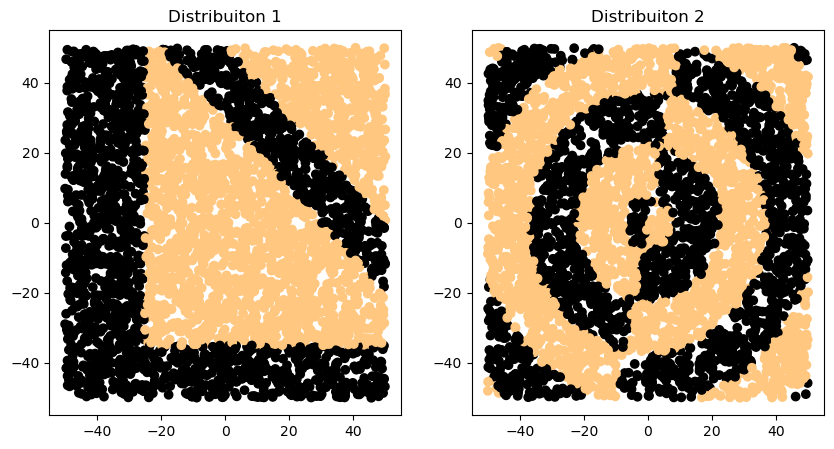

In [43]:
# random seed for reproducibility
np.random.seed(12345)

def generate_data(TYPE):
    x,y = (np.random.random((N,2))-0.5)*B, np.zeros(N)
    for i in range(N):
        # label data according to a nonlinear function "f"
        y[i] = f(x[i],TYPE)
    return x, y

x1, y1 = generate_data(1)
x2, y2 = generate_data(2)

fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axis[0].scatter(x1[:,0],x1[:,1],c=y1,cmap=cm.copper)
axis[0].set_title("Distribuiton 1")
axis[1].scatter(x2[:,0],x2[:,1],c=y2,cmap=cm.copper)
axis[1].set_title("Distribuiton 2")

plt.show

**Generate grid**

In order to predict the labels with a random data, create a grid with the same dimensions of the training set 

In [44]:
#Generate a random grid of lenght 50x50 (which is the size of the raw data)
dX = 2
X1 = np.arange(-50,50+dX, dX)

LG = len(X1)
grid = np.zeros((LG*LG,2))
#print(grid)
k=0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(X1[j],X1[i])
        k=k+1

#Normalize the grid for predicting the model        
grid_r=grid/50

**Define DNN for distribution 1**

Create a DNN model in which the parameters that can be optimized are: optimization algorithm, activation function, network weight initialization, dropout value and number of neurons.


In [55]:
#Write it as a function so KerasClassifier function can work
#If not all hyperparameters will be changed, default values will be taken instead

def create_model(layers=3, optimizer="adam", activation="relu",init_mode='uniform', dropout_rate=0.2, neurons = 20):
    #create model layer by layer
    model = Sequential()
    model.add(Dense(2,input_shape=(2,), kernel_initializer=init_mode, activation='relu'))

    for i in range(1, layers):
        model.add(Dense(neurons, activation=activation, kernel_initializer=init_mode))
        
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,kernel_initializer=init_mode, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

**Optimization for distribution 1**

Optimize the DNN previously defined to obtain the best accuracy.  Use the x1 y1 data wich has 4000 samples in total from the distribution 1.

In [46]:
#Possible hyperparameters to be optimized (layers not working yet)
batch_size = [ 40,60,80,100]
epochs = [200,300,400,500]
optimizer = ["SGD", "Adagrad",  "Adam",  "Nadam" ]
activation = ["softmax",  "relu", "tanh", "sigmoid", "linear"]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
neurons = [15,20,25,30,35]
layers=[2,3]
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero',
              'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']

In [47]:
#create model 
model = KerasClassifier(model=create_model, 
                        batch_size=60,
                          epochs=500
                          )

#Select which ones will be used in the GridSearchCV
#If batch_size or epochs is commented, then it must be written directly in the KerasClassifier
param_grid = dict(
                  #batch_size = batch_size,
                  #epochs=epochs,
                  optimizer=optimizer,
                  #model__activation=activation
                  #model__dropout_rate=dropout_rate
                  #layers=layers
                  #model__neurons=neurons
                  #model__init_mode=init_mode
                   )

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3,verbose=0)
grid_result=grid.fit(x1,y1)

Epoch 1/500
67/67 [==============================] - 3s 1ms/step - loss: 0.6868 - accuracy: 0.5957
Epoch 2/500
67/67 [==============================] - 0s 1ms/step - loss: 0.6181 - accuracy: 0.6463
Epoch 3/500
67/67 [==============================] - 0s 1ms/step - loss: 0.5656 - accuracy: 0.6888
Epoch 4/500
67/67 [==============================] - 0s 997us/step - loss: 0.5443 - accuracy: 0.7092
Epoch 5/500
67/67 [==============================] - 0s 1ms/step - loss: 0.5345 - accuracy: 0.7195
Epoch 6/500
67/67 [==============================] - 0s 911us/step - loss: 0.5244 - accuracy: 0.7237
Epoch 7/500
67/67 [==============================] - 0s 1ms/step - loss: 0.5144 - accuracy: 0.7345
Epoch 8/500
67/67 [==============================] - 0s 997us/step - loss: 0.5075 - accuracy: 0.7412
Epoch 9/500
67/67 [==============================] - 0s 953us/step - loss: 0.5013 - accuracy: 0.7462
Epoch 10/500
67/67 [==============================] - 0s 945us/step - loss: 0.4967 - accuracy: 0.7483

In [48]:
#best parameters for getting high accuracy
best_parameters = grid_result.best_params_
print("The best combination of hyperparameters is: {}".format(best_parameters))
#highest accuracy for previous values
highest_accuracy = grid_result.best_score_
print("The accuracy obtained for those previous values is: {}".format(highest_accuracy))

result = pd.DataFrame(grid_result.cv_results_)
result = result[["param_optimizer","mean_test_score"]]
result

The best combination of hyperparameters is: {'optimizer': 'Adam'}
The accuracy obtained for those previous values is: 0.9157609867234425


,param_optimizer,mean_test_score
0,SGD,0.863011
1,Adagrad,0.881752
2,Adam,0.915761
3,Nadam,0.874249


**Test accuracy with distribution 1**

Separate data from distribution 1 in training set and validation set

In [49]:
#Split data for distribution 1 in training and validation 
d1_train_data, d1_train_label, d1_val_data, d1_val_label = split_data_training_validation(x1, y1, 0.8)

#Normalize data
d1_train_data=Rescale(d1_train_data)
d1_val_data=Rescale(d1_val_data)

print("Train:",len(d1_train_data),"\t Validation:",len(d1_val_data))

Train: 3200 	 Validation: 800


**Test the training and validation set**

In [50]:

#Final neural network for distribution 1 with the hyperparameters obtained in the optimization section

model_1 = Sequential()
model_1.add(Dense(2,input_shape=(2,),kernel_initializer="uniform", activation='relu'))
model_1.add(Dense(25,kernel_initializer="uniform", activation="relu"))
model_1.add(Dense(25,kernel_initializer="uniform", activation="relu"))   
model_1.add(Dense(25,kernel_initializer="uniform", activation="relu"))
model_1.add(Dropout(0.01))
model_1.add(Dense(1,kernel_initializer="uniform", activation='sigmoid'))
model_1.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model_1.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 2)                 6         
                                                                 
 dense_19 (Dense)            (None, 25)                75        
                                                                 
 dense_20 (Dense)            (None, 25)                650       
                                                                 
 dense_21 (Dense)            (None, 25)                650       
                                                                 
 dropout_4 (Dropout)         (None, 25)                0         
                                                                 
 dense_22 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,407
Trainable params: 1,407
Non-traina

In [61]:
# reproducibility
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)

#run model_1
final_model_dsitribution_1= model_1.fit(d1_train_data, d1_train_label,
               epochs = 500, batch_size = 60,
               validation_data=(d1_val_data, d1_val_label),
               verbose=0)

82/82 [==============================] - 0s 958us/step


Text(0.5, 1.0, 'prediction')

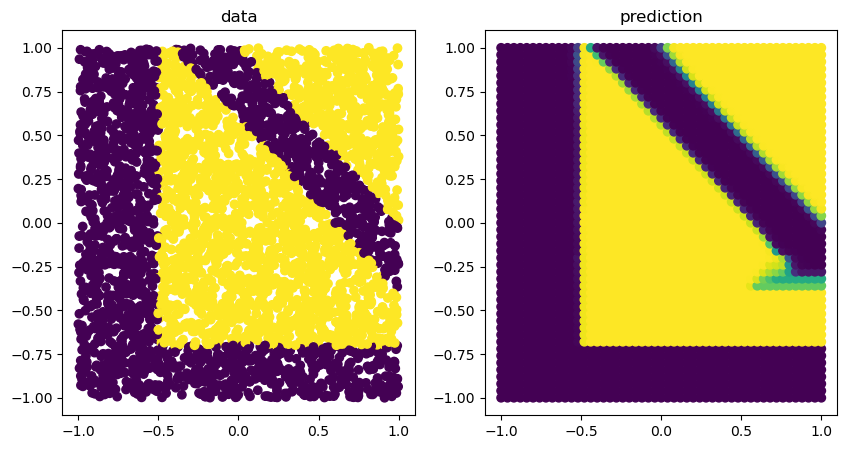

In [62]:
#Predict the possible labels of the grid created previously using the final_model_distribution 1 and plot
pred_optimized = model_1.predict(grid_r)

fig, axis = plt.subplots(1, 2, figsize=(10,5))

#Raw data
axis[0].scatter(x1[:,0]/50,x1[:,1]/50,c=y1)
axis[0].set_title("data")

#Generated with optimization
axis[1].scatter(grid_r[:,0],grid_r[:,1],c=pred_optimized)
axis[1].set_title("prediction")

**Optimization for distribution 2**

Using data from distribution 2, find the best hyperparameters

In [63]:
#create model 
model = KerasClassifier(model=create_model, 
                        batch_size=80,
                        epochs=500
                          )

#Select which ones will be used in the GridSearchCV
#If batch_size or epochs is commented, then it must be written directly in the KerasClassifier
param_grid = dict(
                  #batch_size = batch_size,
                  #epochs=epochs,
                  #optimizer=optimizer,
                  #model__activation=activation,
                  model__dropout_rate=dropout_rate,
                  #layers=layers,
                  model__neurons=neurons
                  #model__init_mode=init_mode
                   )

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=0)
grid_result=grid.fit(x2,y2)

In [ ]:
#best parameters for getting high accuracy
best_parameters = grid_result.best_params_
print("The best combination of hyperparameters is: {}".format(best_parameters))
#highest accuracy for previous values
highest_accuracy = grid_result.best_score_
print("The accuracy obtained for those previous values is: {}".format(highest_accuracy))

The best combination of hyperparameters is: {'model__activation': 'relu', 'optimizer': 'Nadam'}
The accuracy obtained for those previous values is: 0.573251446294857


**Test accuracy with distribution 2**

In [ ]:
#Split data for distribution 1 in training and validation 
d2_train_data, d2_train_label, d2_val_data, d2_val_label = split_data_training_validation(x2, y2, 0.8)

#Normalize data
d2_train_data=Rescale(d2_train_data)
d2_val_data=Rescale(d2_val_data)

print("Train:",len(d2_train_data),"\t Validation:",len(d2_val_data))

Train: 3200 	 Validation: 800


In [ ]:
#Define DNN for distribution 2 using the hyperparameters obtained at the begining 

model_2 = Sequential()
model_2.add(Dense(2,input_shape=(2,),kernel_initializer="uniform", activation='relu'))
model_2.add(Dense(25,kernel_initializer="uniform", activation="relu"))
model_2.add(Dense(25,kernel_initializer="uniform", activation="relu"))   
model_2.add(Dense(25,kernel_initializer="uniform", activation="relu"))
model_2.add(Dropout(0.01))
model_2.add(Dense(1,kernel_initializer="uniform", activation='sigmoid'))
model_2.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 2)                 6         
                                                                 
 dense_10 (Dense)            (None, 25)                75        
                                                                 
 dense_11 (Dense)            (None, 25)                650       
                                                                 
 dense_12 (Dense)            (None, 25)                650       
                                                                 
 dropout_2 (Dropout)         (None, 25)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,407
Trainable params: 1,407
Non-traina

In [ ]:
final_model_dsitribution_2= model_2.fit(d2_train_data, d2_train_label, 
               epochs = 500, batch_size = 60,
               validation_data=(d2_val_data, d2_val_label),
               verbose=0)

82/82 [==============================] - 3s 1ms/step


Text(0.5, 1.0, 'prediction')

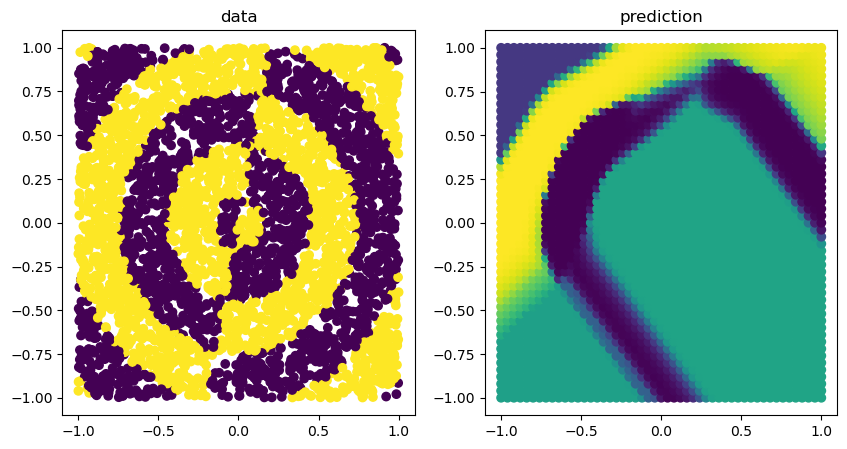

In [ ]:
#Predict the possible labels of the grid created previously using the final_model_distribution 2 and plot
pred_optimized_2 = model_2.predict(grid_r)

fig, axis = plt.subplots(1, 2, figsize=(10,5))

#Raw data
axis[0].scatter(x2[:,0]/50,x2[:,1]/50,c=y2)
axis[0].set_title("data")

#Generated data without optimization

axis[1].scatter(grid_r[:,0],grid_r[:,1],c=pred_optimized_2)
axis[1].set_title("prediction")

[[0.56522125]
 [0.56522125]
 [0.56522125]
 ...
 [0.9798096 ]
 [0.9761397 ]
 [0.97998327]]
